In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from IPython.display import clear_output
import time
from data_processing_13_part3_model import compute_smoothed_trajectory, process_ekf_segments, extract_observations, get_current_observations, get_trajectory_for_time, create_uncertainty_ellipse

In [2]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})


In [ ]:
# The chart has both right and left side data points

def create_jupyter_animation(subject_data):
    
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    step = 1
    
    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)
        
        current_data = data_sorted.iloc[:i+1]
        
        plt.figure(figsize=(14, 10))
        left_data = current_data[current_data['side'] == 'left']
        right_data = current_data[current_data['side'] == 'right']
        
        if len(left_data) > 0:
            plt.scatter(left_data['X'], left_data['Y'], c='red', s=50, alpha=0.5, label='Left Side')
        
        if len(right_data) > 0:
            plt.scatter(right_data['X'], right_data['Y'], c='blue', s=50, alpha=0.5, label='Right Side')
        
        if i < len(data_sorted):
            current_point = data_sorted.iloc[i]
            color = 'red' if current_point['side'] == 'left' else 'blue'
            plt.scatter(current_point['X'], current_point['Y'], c=color, s=100, alpha=1.0, edgecolors='black', linewidth=2, marker='o')
        
        plt.xlim(0, 15)
        plt.ylim(0, 9)
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Starfish Movement - Point {i+1}/{len(data_sorted)}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.show()
        time.sleep(0.05)

create_jupyter_animation(subject_data)

In [ ]:
# The charts have right and left side data points animated in different subplots

def separate_animation(subject_data):

    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    step = 1

    fig, axs = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True)

    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)

        # Clear previous plots
        for ax in axs:
            ax.clear()
            ax.set_xlim(0, 15)
            ax.set_ylim(0, 9)
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.grid(True, alpha=0.3)

        current_data = data_sorted.iloc[:i+1]

        # Left
        left_data = current_data[current_data['side'] == 'left']
        axs[0].scatter(left_data['X'], left_data['Y'], c='red', s=50, alpha=0.5, label='Left')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'left':
            point = current_data.iloc[-1]
            axs[0].scatter(point['X'], point['Y'], c='red', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[0].legend()
        axs[0].set_title(f'Left Side Movement')

        # Right
        right_data = current_data[current_data['side'] == 'right']
        axs[1].scatter(right_data['X'], right_data['Y'], c='blue', s=50, alpha=0.5, label='Right')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'right':
            point = current_data.iloc[-1]
            axs[1].scatter(point['X'], point['Y'], c='blue', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[1].legend()
        axs[1].set_title(f'Right Side Movement')

        plt.tight_layout()
        display(fig)
        time.sleep(0.05)

separate_animation(subject_data) 

In [ ]:
# The chart of EKF smoothed trajectory only

def ekf_trajectory_animation(subject_data, final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], dt_virt=0.5, save_gif=False, gif_filename='ekf__animation.gif'):
    
    s_smooth = compute_smoothed_trajectory(subject_data, final_params, dt_virt)
    
    subject_data_processed = subject_data.copy()
    subject_data_processed['TIME'] = pd.to_datetime(subject_data_processed['TIME'])
    t0 = subject_data_processed['TIME'].min()
    subject_data_processed['timestamp'] = (subject_data_processed['TIME'] - t0).dt.total_seconds()

    timestamps = subject_data_processed['timestamp'].values
    virtual_ts = np.arange(min(timestamps), max(timestamps), dt_virt)
    
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(15, 9))

    step = 10
    
    def animate(frame):
            for i in range(0, len(data_sorted), step):
                clear_output(wait=True)
                
                ax.clear()
                ax.set_xlim(0, 15)
                ax.set_ylim(0, 9)
                ax.set_xlabel('X Position')
                ax.set_ylabel('Y Position')
                ax.grid(True, alpha=0.3)
                ax.set_title('EKF Smoothed Trajectory')
                
                current_data = data_sorted.iloc[:i+1]
                current_time = current_data.iloc[-1]['TIME'] if not current_data.empty else data_sorted.iloc[0]['TIME']
                
                current_timestamp = (pd.to_datetime(current_time) - t0).total_seconds()
                
                ekf_idx = np.searchsorted(virtual_ts, current_timestamp)
                ekf_idx = min(ekf_idx, len(s_smooth) - 1)
                
                # Show raw sensor data up to current time
                left_data = current_data[current_data['side'] == 'left']
                right_data = current_data[current_data['side'] == 'right']
                
                ax.scatter(left_data['X'], left_data['Y'], c='red', s=30, alpha=0.4, label='Left Sensor')
                ax.scatter(right_data['X'], right_data['Y'], c='blue', s=30, alpha=0.4, label='Right Sensor')
                
                if ekf_idx > 0:
                    x_coords = [s[0] for s in s_smooth[:ekf_idx+1]]
                    y_coords = [s[1] for s in s_smooth[:ekf_idx+1]]
                    
                    ax.plot(x_coords, y_coords, 'g-', linewidth=2, label='EKF Trajectory')
                    
                    if ekf_idx < len(s_smooth):
                        current_x, current_y = s_smooth[ekf_idx][0], s_smooth[ekf_idx][1]
                        ax.scatter(current_x, current_y, c='green', s=150, edgecolors='black', linewidth=2, marker='o', zorder=5)
                
                ax.legend()
                display(fig)
                time.sleep(0.01)

    frames = range(0, len(data_sorted), step)
    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100, repeat=True)

    if save_gif:
        ani.save(gif_filename, writer='pillow', fps=10)
    
    return ani

ekf_trajectory_animation(subject_data, save_gif=False)

### Visualize the range of the potential angle
### Check the consistency of the time stamps for both sensor data and ekf smoothed trajectory
### Add furniture plot in the chart
### Rethink about the structure of the ekf filter on the data: 1. same model for the entire data; 2. loop the filter on time segments separately
### Figure out the multi processing method
### Checked the sorted data
### Visualize the facing angle
### Merge the sigma vx and sigma vy
### Rerun EKF with loops and UKF with packages
#### keep the state_mean function, for angle, can modify:
#### def residual(a, b):
####    y = a[0] - b[0]
####    if y == np.pi:
####        y -= 2*np.pi
####    while ... y < -np.pi:
####        y = 2*np.pi
####    return y

Creating animation with 2159 frames...


/Users/yurifu/miniconda3/envs/conda_venv/lib/python3.12/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


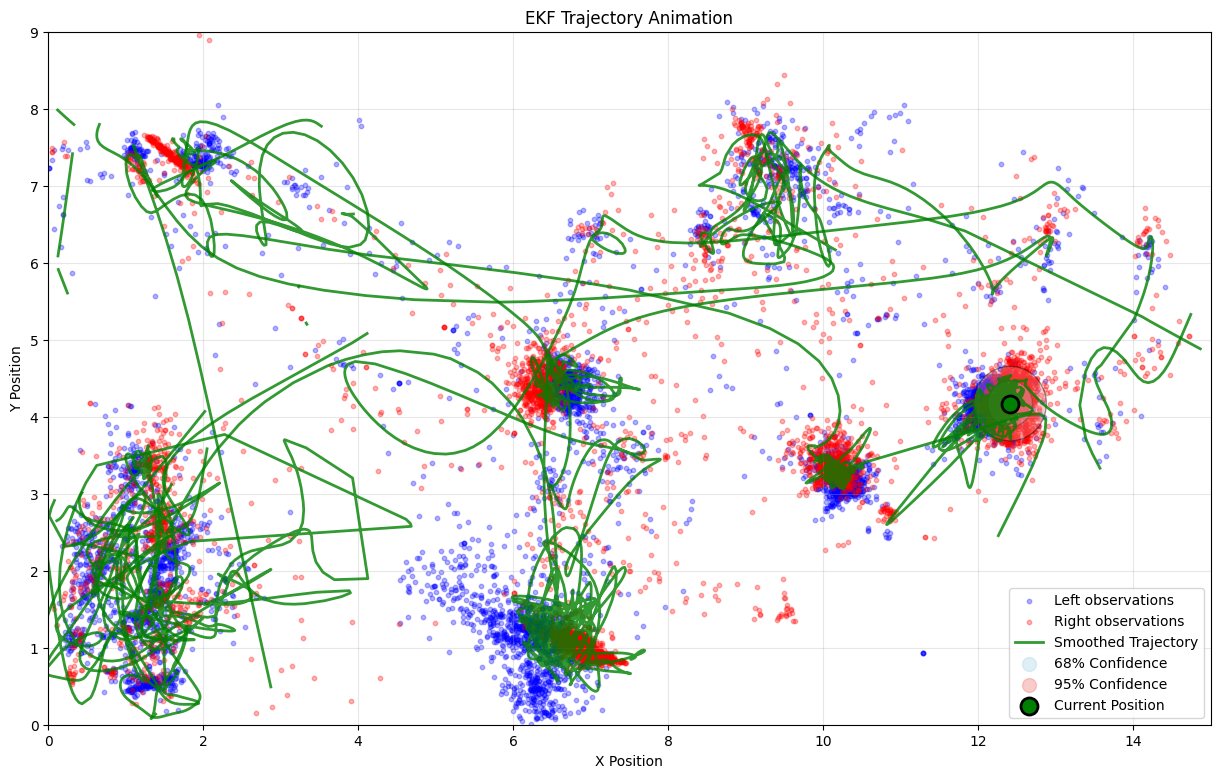

In [ ]:
# The chart of EKF smoothed trajectory with time segments

def ekf_trajectory_animation(subject_data, 
                           final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], 
                           dt_virt=0.5, 
                           save_gif=False, 
                           gif_filename='ekf_animation.gif', 
                           show_uncertainty=True, 
                           confidence_levels=[0.68, 0.95],
                           time_step=5,
                           xlim=(0, 15),
                           ylim=(0, 9)):

    real_data, time_segments = compute_smoothed_trajectory(subject_data, final_params, dt_virt)   
    segment_trajectories = process_ekf_segments(time_segments, final_params, dt_virt)

    (left_x, left_y), (right_x, right_y) = extract_observations(real_data)
    
    all_timestamps = [entry['timestamp'] for entry in real_data]
    min_time, max_time = min(all_timestamps), max(all_timestamps)
    animation_times = np.arange(min_time, max_time + time_step, time_step)
    
    fig, ax = plt.subplots(figsize=(15, 9))
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    
    def animate_frame(frame):
        current_time = animation_times[frame]
        ax.clear()
        ax.set_title(f'EKF Trajectory Animation')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        (current_left_x, current_left_y), (current_right_x, current_right_y) = get_current_observations(real_data, current_time)
        
        if current_left_x:
            ax.scatter(current_left_x, current_left_y, color='blue', alpha=0.3, s=10, label='Left observations')
        if current_right_x:
            ax.scatter(current_right_x, current_right_y, color='red', alpha=0.3, s=10, label='Right observations')
        
        trajectory_data, current_position, current_covariance = get_trajectory_for_time(segment_trajectories, current_time)
        
        first_trajectory = True
        for traj in trajectory_data:
            label = 'Smoothed Trajectory' if first_trajectory else None
            first_trajectory = False
            ax.plot(traj['x'], traj['y'], 'g-', alpha=0.8, linewidth=2, label=label)
        
        if show_uncertainty and current_position and current_covariance is not None:
            for j, conf_level in enumerate(confidence_levels):
                ellipse_params = create_uncertainty_ellipse(current_position, current_covariance, conf_level)
                
                ellipse = Ellipse(xy=ellipse_params['center'],
                                width=ellipse_params['width'], 
                                height=ellipse_params['height'],
                                angle=ellipse_params['angle'],
                                facecolor=colors[j % len(colors)], 
                                alpha=0.4, 
                                edgecolor='black', 
                                linewidth=1.0)
                ax.add_patch(ellipse)
        
        if show_uncertainty:
            for j, conf_level in enumerate(confidence_levels):
                ax.scatter([], [], color=colors[j % len(colors)], alpha=0.4, s=100, 
                          label=f'{conf_level*100:.0f}% Confidence')
        
        if current_position:
            ax.scatter(current_position[0], current_position[1], c='green', s=150, 
                      edgecolors='black', linewidth=2, marker='o', zorder=5, 
                      label='Current Position')
        
        ax.legend()
    
    ani = animation.FuncAnimation(fig, animate_frame, frames=len(animation_times), interval=50, repeat=True, blit=False)
    ani.save(gif_filename, writer='pillow', fps=10)
    
    return ani


ani = ekf_trajectory_animation(subject_data, confidence_levels=[0.68, 0.95], time_step=5)

plt.show()